# Data Preparation for All-Decade Teams'

In this notebook we will prepare the data for both WNBA All-Decade Team and WNBA All Decade Team Honorable Mention awards predictions.

#### Load Dependencies

In [75]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player performance statistics for All-Decade Team analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.
- **Convert Key Stats to Float:** Ensure important performance statistics are numeric for accurate calculations.
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.
- **Sort Data:** Organize the aggregated data by player and year for multi-year computations.

In [76]:
alldecade_players_info_df = sd.players_teams_df.copy()

cols_to_agg = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgMade', 'fgAttempted', 'GP']

for col in cols_to_agg:
    alldecade_players_info_df[col] = alldecade_players_info_df[col].astype(float)

alldecade_players_info_df = alldecade_players_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

alldecade_players_info_df = alldecade_players_info_df.sort_values(['playerID', 'year'])

#### Compute Player Score

This section defines a function to calculate overall performance scores:

- **Define Function:** Create overall_performance function combining stats.  
- **Apply Weights:** Weight points, rebounds, assists, steals, blocks, turnovers, FG%, GP.

In [77]:
def overall_performance(PTS, REB, AST, STL, BLK, TOV, FGM, FGA, GP):
    if GP == 0 or FGA == 0:
        return 0 
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )


#### Calculate Multi-Year Defensive Scores

This section computes performance scores for multiple previous years:

- **Shift Data:** Use groupby shift for years 1 to 9.  
- **Apply Function:** Calculate scores using overall_performance for each shift.  
- **Sum Scores:** Combine scores across all years for each player.

In [78]:
all_scores = []

for shift_years in range(1, 10):
    col_suffix = f"prev_{shift_years}yr"

    shifted_points      = alldecade_players_info_df.groupby('playerID')['points'].shift(shift_years)
    shifted_assists     = alldecade_players_info_df.groupby('playerID')['assists'].shift(shift_years)
    shifted_turnovers   = alldecade_players_info_df.groupby('playerID')['turnovers'].shift(shift_years)
    shifted_fgMade      = alldecade_players_info_df.groupby('playerID')['fgMade'].shift(shift_years)
    shifted_fgAttempted = alldecade_players_info_df.groupby('playerID')['fgAttempted'].shift(shift_years)
    shifted_gp          = alldecade_players_info_df.groupby('playerID')['GP'].shift(shift_years)
    shifted_rebounds    = alldecade_players_info_df.groupby('playerID')['rebounds'].shift(shift_years)
    shifted_steals      = alldecade_players_info_df.groupby('playerID')['steals'].shift(shift_years)
    shifted_pf          = alldecade_players_info_df.groupby('playerID')['blocks'].shift(shift_years)

    overall_performance_scores = pd.Series(
        [
            overall_performance(
                shifted_points.iloc[i], shifted_rebounds.iloc[i],
                shifted_assists.iloc[i], shifted_steals.iloc[i],
                shifted_pf.iloc[i], shifted_turnovers.iloc[i],
                shifted_fgMade.iloc[i], shifted_fgAttempted.iloc[i],
                shifted_gp.iloc[i]
            ) if (not pd.isna(shifted_gp.iloc[i]) and shifted_gp.iloc[i] > 0)
            else 0
            for i in range(len(alldecade_players_info_df))
        ],
        index=alldecade_players_info_df.index
    )

    all_scores.append(overall_performance_scores.fillna(0))

alldecade_players_info_df['overall_score_sum'] = sum(all_scores)

#### Merge All-Decade Team Awards Information And The Sum of the Scores of each Season

This section merges award information and calculates best scores:

- **Filter Awards:** Select all-decade team and honorable mention awards.  
- **Assign Values:** Set alldecade to 2 or 1.  
- **Merge Players:** Combine with players_df.  
- **Calculate Best:** Filter years <=6, group by player for max score, merge.

In [79]:
alldecade_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'wnba all-decade team'].drop_duplicates(subset=['playerID', 'year']).copy()
alldecade_aw['alldecade'] = 2

alldecade_mention_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'wnba all decade team honorable mention'].drop_duplicates(subset=['playerID', 'year']).copy()
alldecade_mention_aw['alldecade'] = 1

alldecade_combined = pd.concat([
    alldecade_aw[['playerID', 'year', 'alldecade']],
    alldecade_mention_aw[['playerID', 'year', 'alldecade']]
], ignore_index=True)

allplayers_decade_info_df = sd.players_df.copy()

allplayers_decade_info_df = allplayers_decade_info_df.rename(columns={'bioID': 'playerID'})

allplayers_decade_info_df = allplayers_decade_info_df.merge(
    alldecade_combined[['playerID', 'alldecade', 'year']],
    on=['playerID'],
    how='left'
)

allplayers_decade_info_df['alldecade'] = allplayers_decade_info_df['alldecade'].fillna(0).astype(int)

filtered_df = alldecade_players_info_df[
    (alldecade_players_info_df['year'] <= 6) 
]

best_scores = (
    filtered_df
    .groupby('playerID')['overall_score_sum']
    .max()
    .reset_index()
    .rename(columns={'overall_score_sum': 'best_overall_score'})
)

allplayers_decade_info_df = allplayers_decade_info_df.merge(
    best_scores,
    on='playerID',
    how='left'
)

allplayers_decade_info_df['best_overall_score'] = allplayers_decade_info_df['best_overall_score'].fillna(0)

#### Added All The Awards The Player had on The Decade

This section counts total awards each player received:

- **Filter Awards:** Select awards from years <7.  
- **Group and Count:** Group by playerID and count awards.  
- **Merge Counts:** Add the count to the dataframe.

In [80]:
number_of_awards = sd.awards_players_df[sd.awards_players_df['year'] < 7]

award_counts = (
    number_of_awards
    .groupby('playerID')
    .size()
    .reset_index(name='number_of_awards')
)

allplayers_decade_info_df = allplayers_decade_info_df.merge(
    award_counts,
    on='playerID',
    how='left'
)

allplayers_decade_info_df['number_of_awards'] = allplayers_decade_info_df['number_of_awards'].fillna(0).astype(int)

#### Remove Columns and Rows and Save CSV

This section cleans and saves the dataset:

- **Remove Columns:** Remove unnecessary columns like pos, height, etc.  
- **Remove Rows:** Keep only rows where best_overall_score != 0 (that means only players that have played).
- **Save to CSV:** Export to all-decade_teams.csv.

In [81]:
allplayers_decade_info_df.drop(
    columns=['pos', 'height', 'weight', 'college', 'collegeOther', 'birthDate', 'deathDate'],
    inplace=True
)

allplayers_decade_info_df = allplayers_decade_info_df[allplayers_decade_info_df['best_overall_score'] != 0]

column_order = [
    'playerID',
    'year',
    'best_overall_score',
    'number_of_awards',
    'alldecade'
]
allplayers_decade_info_df = allplayers_decade_info_df[column_order]

allplayers_decade_info_df.to_csv("../predict_datasets/all-decade_teams.csv", index=False)

#### Idea For the Dataset Preparation

Since this dataset is for All-Decade teams, the ideal approach would be to evaluate player performance over the ten years preceding the awards. In a fair assessment, each year within that decade should be weighted equally, ensuring that the first year does not count for less than, for example, the seventh year.

However, when constructing our training dataset, we faced a limitation: the awards were given in the seventh year of our available data, which prevented us from using a full ten year window. Therefore, we adjusted our methodology to calculate each player’s score based on six years of data before the award.

#### Data Correlation Analysis

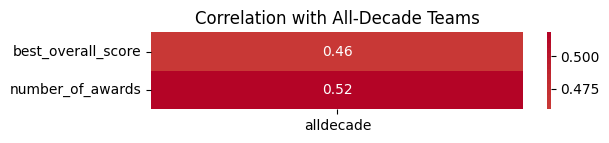

In [82]:
score_cols = ['best_overall_score', 'number_of_awards', 'alldecade']
df_scores = allplayers_decade_info_df[score_cols]

corr_matrix = df_scores.corr()[['alldecade']]

corr_matrix = corr_matrix.drop('alldecade')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with All-Decade Teams")
plt.show()